# Homework 4

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import scale, StandardScaler

Imdb dataset from https://ai.stanford.edu/~amaas/data/sentiment/

In [2]:
from sklearn.datasets import load_files
# https://ai.stanford.edu/~amaas/data/sentiment/
reviews_train = load_files("../aclImdb/train/")
# load_files returns a bunch, containing training texts and training labels
text_trainval, y_trainval = reviews_train.data, reviews_train.target

# Bag of words 

In [3]:
from sklearn.feature_extraction.text import CountVectorizer

In [4]:
text_trainval = [doc.replace(b"<br />", b" ") for doc in text_trainval]

text_train, text_val, y_train, y_val = train_test_split(
    text_trainval, y_trainval, stratify=y_trainval, random_state=0)


In [5]:
text_train[0]

b'Flatland is one of my favorite books, thus I was looking forward to this film. Unfortunately, the film is absolutely horrible. The dialog is so bad it sounds like improv half the time. The new storyline makes me think they took the book and a couple of newspapers, threw them in a blender and used what came out for the screenplay. It\'s a disgrace to the book and independent film making. The only reason I even managed to get all the way through the film was my hopes that it\'d get better. Unfortunately, it only got worse, climaxing in a really retarded ending.  That\'s not to say EVERYTHING about the movie is bad. The CG is acceptable, in a 1990\'s "Reboot" sort of way which I assume is what they were going for. And I suppose you can\'t go wrong with "people" getting chopped in half and gushing blood all over the place.'

## 1 custermize your countvectorizer (10 pts)

In [6]:
vect = CountVectorizer(stop_words= 'english', ngram_range=(1,3), min_df = 4)

In [7]:
X_train = vect.fit_transform(text_train)
X_val = vect.transform(text_val)

In [8]:
len(vect.get_feature_names())

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


256354

In [9]:
y_train

array([2, 1, 0, ..., 2, 2, 2])

## 2 train a random forest model (20 pts)

In [10]:
from sklearn.ensemble import RandomForestClassifier

In [11]:
rf = RandomForestClassifier()

train score and validation score

In [12]:
rf.fit(X_train, y_train)

RandomForestClassifier()

In [13]:
rf.score(X_train, y_train)

0.9964444444444445

In [14]:
rf.score(X_val, y_val)

0.6670933333333333

## 3 plot feature importance (10 pts)

In [15]:
def plot_important_features(coef, feature_names, top_n=20, ax=None, rotation=60):
    if ax is None:
        ax = plt.gca()
    inds = np.argsort(coef)
#     low = inds[:top_n]
    high = inds[-top_n:]
    important = high
    myrange = range(len(important))
#     colors = ['red'] * top_n + ['blue'] * top_n
    
    ax.bar(myrange, coef[important])
    ax.set_xticks(myrange)
    ax.set_xticklabels(feature_names[important], rotation=rotation, ha="right")
    ax.set_xlim(-.7,  top_n)
    ax.set_frame_on(False)

In [16]:
coef = rf.feature_importances_
coef

array([2.66278201e-05, 2.65946175e-09, 1.87653657e-06, ...,
       4.77003335e-07, 6.21761572e-07, 0.00000000e+00])

In [18]:
feature_names = np.array(vect.get_feature_names())

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


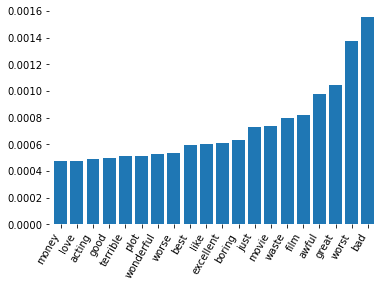

In [19]:
plot_important_features(coef, feature_names, top_n=20, ax=None, rotation=60)

# LDA

In [20]:
from sklearn.decomposition import LatentDirichletAllocation

## 4 learn a topic model with LDA (20 pts)

In [21]:
lda = LatentDirichletAllocation(n_components=10, learning_method="batch")
X_lda = lda.fit_transform(X_train)

In [22]:
components =lda.components_

In [23]:
np.argsort(X_lda.sum(axis=0))[::-1]

array([3, 2, 6, 0, 9, 5, 1, 8, 4, 7], dtype=int64)

## 5 visualize the topic model (10 pts)

In [24]:
def print_topics(topics, feature_names, components, topics_per_chunk=6,
                 n_words=20):
    sorting = np.argsort(components, axis=1)[:, ::-1]
    for i in range(0, len(topics), topics_per_chunk):
        # for each chunk:
        these_topics = topics[i: i + topics_per_chunk]
        # maybe we have less than topics_per_chunk left
        len_this_chunk = len(these_topics)
        # print topic headers
        print(("topic {:<8}" * len_this_chunk).format(*these_topics))
        print(("-------- {0:<5}" * len_this_chunk).format(""))
        # print top n_words frequent words
        for i in range(n_words):
            try:
                print(("{:<14}" * len_this_chunk).format(
                    *feature_names[sorting[these_topics, i]]))
            except:
                pass
        print("\n")

In [25]:
# sorting = np.argsort(lda100.components_, axis=1)[:, ::-1]
print_topics(np.argsort(X_lda.sum(axis=0))[::-1], feature_names, components, topics_per_chunk=8)

topic 3       topic 2       topic 6       topic 0       topic 9       topic 5       topic 1       topic 8       
--------      --------      --------      --------      --------      --------      --------      --------      
movie         film          film          film          film          movie         movie         movie         
just          life          like          films         like          like          film          time          
like          story         just          like          comedy        series        bad           like          
good          movie         movie         good          movie         story         just          film          
really        people        plot          horror        funny         good          like          just          
film          time          good          story         just          time          good          great         
bad           man           people        best          people        just          seen        

# Word Embedding

## 6 pretrained word embedding + RNN (30 pts)

In [26]:
import spacy
nlp = spacy.load("en_core_web_md", disable=["tagger", "parser", "ner"])

In [27]:
nlp.vocab.vectors.shape

(20000, 300)

In [28]:
nlp('word').vector.shape

C:\ProgramData\Anaconda3\lib\site-packages\spacy\pipeline\lemmatizer.py:211: UserWarning: [W108] The rule-based lemmatizer did not find POS annotation for one or more tokens. Check that your pipeline includes components that assign token.pos, typically 'tagger'+'attribute_ruler' or 'morphologizer'.
  warnings.warn(Warnings.W108)


(300,)

In [29]:
text_train = text_train[:10]
y_train=y_train[:10]
text_train

[b'Flatland is one of my favorite books, thus I was looking forward to this film. Unfortunately, the film is absolutely horrible. The dialog is so bad it sounds like improv half the time. The new storyline makes me think they took the book and a couple of newspapers, threw them in a blender and used what came out for the screenplay. It\'s a disgrace to the book and independent film making. The only reason I even managed to get all the way through the film was my hopes that it\'d get better. Unfortunately, it only got worse, climaxing in a really retarded ending.  That\'s not to say EVERYTHING about the movie is bad. The CG is acceptable, in a 1990\'s "Reboot" sort of way which I assume is what they were going for. And I suppose you can\'t go wrong with "people" getting chopped in half and gushing blood all over the place.',
 b'In an attempt to cash in on the success of Universal\'s horror films Majestic Pictures hired several popular actors from the current genre and put them in this e

In [31]:
import gensim
x_train = [gensim.utils.simple_preprocess(text) for text in text_train]

In [32]:
len(x_train[1])

494

In [33]:
x_train

[['flatland',
  'is',
  'one',
  'of',
  'my',
  'favorite',
  'books',
  'thus',
  'was',
  'looking',
  'forward',
  'to',
  'this',
  'film',
  'unfortunately',
  'the',
  'film',
  'is',
  'absolutely',
  'horrible',
  'the',
  'dialog',
  'is',
  'so',
  'bad',
  'it',
  'sounds',
  'like',
  'improv',
  'half',
  'the',
  'time',
  'the',
  'new',
  'storyline',
  'makes',
  'me',
  'think',
  'they',
  'took',
  'the',
  'book',
  'and',
  'couple',
  'of',
  'newspapers',
  'threw',
  'them',
  'in',
  'blender',
  'and',
  'used',
  'what',
  'came',
  'out',
  'for',
  'the',
  'screenplay',
  'it',
  'disgrace',
  'to',
  'the',
  'book',
  'and',
  'independent',
  'film',
  'making',
  'the',
  'only',
  'reason',
  'even',
  'managed',
  'to',
  'get',
  'all',
  'the',
  'way',
  'through',
  'the',
  'film',
  'was',
  'my',
  'hopes',
  'that',
  'it',
  'get',
  'better',
  'unfortunately',
  'it',
  'only',
  'got',
  'worse',
  'climaxing',
  'in',
  'really',
  're

In [34]:
docs_train = [[nlp(d).vector for d in s] for s in x_train]

In [35]:
docs_train[0][0].shape

(300,)

In [36]:
from tensorflow import keras
from tensorflow.keras import layers

In [37]:
X_train = keras.preprocessing.sequence.pad_sequences(docs_train, dtype= float, maxlen = 100)
X_train= X_train.transpose(0, 2, 1)

In [38]:
X_train.shape

(10, 300, 100)

In [39]:
X_train[0]

array([[ -2.14240003, -12.66699982,  -2.05970001, ...,  -1.18640006,
         -5.10430002,  -0.96166998],
       [ -3.27250004,  -6.56799984,  -1.85909998, ...,  -2.73749995,
          2.34960008,   1.54340005],
       [ -0.50777   ,  -0.61536998,  -2.90210009, ...,  -7.9368    ,
          3.24720001,   0.44964999],
       ...,
       [  1.05509996,  -8.00209999,  -1.87650001, ...,   0.22753   ,
         -7.6875    ,  -4.15250015],
       [ -3.73090005,  -0.31711999,  -1.42159998, ...,  -6.33920002,
         -2.51279998,   2.53209996],
       [ -0.35279   ,  -7.70620012,  -2.55620003, ...,   3.26690006,
          0.69341999,  -1.98749995]])

In [40]:
y_train

array([2, 1, 0, 2, 2, 2, 2, 2, 1, 2])

In [44]:
y_t = pd.get_dummies(y_train)
y_t.shape

(10, 3)

In [45]:
y_t

,0,1,2
0,0,0,1
1,0,1,0
2,1,0,0
3,0,0,1
4,0,0,1
5,0,0,1
6,0,0,1
7,0,0,1
8,0,1,0
9,0,0,1


In [46]:
# Input for variable-length sequences of integers
inputs = keras.Input(shape=(300, 100), dtype="float")
# Add 2 bidirectional LSTMs
x1 = layers.Bidirectional(layers.LSTM(64, return_sequences=True))(inputs)
x2 = layers.Bidirectional(layers.LSTM(64))(x1)
# Add a classifier
outputs = layers.Dense(3, activation="softmax")(x2)
model = keras.Model(inputs, outputs)
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 300, 100)]        0         
                                                                 
 bidirectional (Bidirectiona  (None, 300, 128)         84480     
 l)                                                              
                                                                 
 bidirectional_1 (Bidirectio  (None, 128)              98816     
 nal)                                                            
                                                                 
 dense (Dense)               (None, 3)                 387       
                                                                 
Total params: 183,683
Trainable params: 183,683
Non-trainable params: 0
_________________________________________________________________


In [47]:
X_train.shape

(10, 300, 100)

In [48]:
model.compile("adam", "binary_crossentropy", metrics=["accuracy"])
model.fit(X_train, y_t, batch_size=10, epochs=2)
# model.fit(X_train, y_train, batch_size=32, epochs=2, validation_data=(X_val, y_val))

Epoch 1/2
1/1 [==============================] - 5s 5s/step - loss: 0.6904 - accuracy: 0.4000
Epoch 2/2
1/1 [==============================] - 0s 118ms/step - loss: 0.5867 - accuracy: 1.0000


In [49]:
y_proba = model.predict(X_train)

1/1 [==============================] - 2s 2s/step


In [50]:
y_proba

array([[0.24980551, 0.27227017, 0.47792426],
       [0.30224618, 0.42826515, 0.2694886 ],
       [0.43997037, 0.23192507, 0.32810453],
       [0.18772128, 0.2029685 , 0.6093102 ],
       [0.15223727, 0.16961512, 0.67814755],
       [0.20158395, 0.19371907, 0.60469705],
       [0.20299873, 0.21479079, 0.5822104 ],
       [0.1620244 , 0.18734288, 0.6506327 ],
       [0.25595388, 0.42637914, 0.31766695],
       [0.22555935, 0.27998698, 0.49445367]], dtype=float32)

In [51]:
y_pred = np.argmax(y_proba, axis =1)

In [52]:
y_pred

array([2, 1, 0, 2, 2, 2, 2, 2, 1, 2], dtype=int64)

In [53]:
from sklearn.metrics import classification_report

In [54]:
print(classification_report(y_train, y_pred))

              precision    recall  f1-score   support

           0       1.00      1.00      1.00         1
           1       1.00      1.00      1.00         2
           2       1.00      1.00      1.00         7

    accuracy                           1.00        10
   macro avg       1.00      1.00      1.00        10
weighted avg       1.00      1.00      1.00        10



## (Optional) 7 use BERT/transformers for text classification (20 pts)